In [1]:
import os
from typing import Union, Tuple, Optional, List
from datetime import datetime
import sys
import subprocess
import gc
import glob
import json
import math
import random
import time
from datetime import datetime
from collections import Counter, defaultdict

import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
get_ipython().magic(u'matplotlib inline')
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sys.path.append("../input/my-pipeline/code/")

In [2]:
class Config:
    competition_name = "h-and-m-personalized-fashion-recommendations"
    exp_name = "eda"
    input_dir = f"../input/h-and-m-personalized-fashion-recommendations/"
    output_dir = f"./" 
    model_dir = f"./"
    log_dir = f"./"
    seed = 42

In [3]:
from utils.logger import Logger
from utils.reduce_mem_usage import reduce_mem_usage
from utils.timer import Timer
from utils.util import decorate
logger = Logger(path=Config.log_dir, exp_name=Config.exp_name)

In [4]:
with Timer(logger=logger, prefix="loading articles.csv"):
    art_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
    logger.info(decorate("art_df.shape"))
    logger.info(art_df.shape)
    
with Timer(logger=logger, prefix="loading custmer.csv"):
    customer_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
    logger.info(decorate("customer_df.shape"))
    logger.info(customer_df.shape)
    
with Timer(logger=logger, prefix="loading train.csv"):
    train_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
    logger.info(decorate("train_df.shape"))
    logger.info(train_df.shape)
    
with Timer(logger=logger, prefix="loading sample_submission.csv"):
    sub_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv")
    logger.info(decorate("sub_df.shape"))
    logger.info(sub_df.shape)

[2022-02-08 08:53:39] - ******************** art_df.shape ********************
[2022-02-08 08:53:39] - (105542, 25)
[2022-02-08 08:53:39] - loading articles.csv 1.320[s]
[2022-02-08 08:53:46] - ******************** customer_df.shape ********************
[2022-02-08 08:53:46] - (1371980, 7)
[2022-02-08 08:53:46] - loading custmer.csv 6.542[s]
[2022-02-08 08:55:01] - ******************** train_df.shape ********************
[2022-02-08 08:55:01] - (31788324, 5)
[2022-02-08 08:55:01] - loading train.csv 75.642[s]
[2022-02-08 08:55:07] - ******************** sub_df.shape ********************
[2022-02-08 08:55:07] - (1371980, 2)
[2022-02-08 08:55:07] - loading sample_submission.csv 5.758[s]


In [5]:
print(art_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [6]:
print(customer_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB
None


In [7]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB
None


In [8]:
print(sub_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   customer_id  1371980 non-null  object
 1   prediction   1371980 non-null  object
dtypes: object(2)
memory usage: 20.9+ MB
None


In [9]:
with Timer(logger=logger, prefix="reduce_mem_usage"):
    art_df = reduce_mem_usage(art_df)
    print("*" * 30)
    customer_df = reduce_mem_usage(customer_df)
    print("*" * 30)
    train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 20.13 MB
Memory usage after optimization is: 7.25 MB
Decreased by 64.0%
******************************
Memory usage of dataframe is 73.27 MB
Memory usage after optimization is: 74.41 MB
Decreased by -1.6%
******************************
Memory usage of dataframe is 1212.63 MB


[2022-02-08 08:55:32] - reduce_mem_usage 23.263[s]


Memory usage after optimization is: 436.77 MB
Decreased by 64.0%


In [10]:
with Timer(logger=logger, prefix="check isnull sum"):
    print(decorate("train_df"))
    print(train_df.isnull().sum())
    print(decorate("art_df"))
    print(art_df.isnull().sum())
    print(decorate("customer_df"))
    print(customer_df.isnull().sum())

******************** train_df ********************


[2022-02-08 08:55:32] - check isnull sum 0.395[s]


t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64
******************** art_df ********************
article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0


In [11]:
with Timer(logger=logger, prefix="check stats info"):
    print(decorate("train stats info"))
    print(train_df.describe())
    print(decorate("customer stats info"))
    print(customer_df.describe())
    
print(decorate("art stats info"))
art_df.describe()

******************** train stats info ********************
          article_id         price  sales_channel_id
count  31788324.0000 31788324.0000     31788324.0000
mean  696227219.0051           NaN            1.7040
std   133448003.4874        0.0000            0.4565
min   108775015.0000        0.0000            1.0000
25%   632803008.0000        0.0158            1.0000
50%   714582003.0000        0.0254            2.0000
75%   786524001.0000        0.0339            2.0000
max   956217002.0000        0.5913            2.0000
******************** customer stats info ********************


[2022-02-08 08:55:43] - check stats info 10.486[s]


               FN      Active          age
count 476930.0000 464404.0000 1356119.0000
mean          NaN         NaN          NaN
std        0.0000      0.0000       0.0000
min        1.0000      1.0000      16.0000
25%        1.0000      1.0000      24.0000
50%        1.0000      1.0000      32.0000
75%        1.0000      1.0000      49.0000
max        1.0000      1.0000      99.0000
******************** art stats info ********************


,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000,105542.0000
mean,698424569.0969,698424.5634,234.8619,1009515.0757,32.2338,3.2062,7.8080,4532.7778,3.1715,42.6642,1010.4383
std,128462381.3362,128462.3844,75.0493,22413.5858,28.0862,1.5638,5.3767,2712.6920,4.3532,23.2601,6.7310
min,108775015.0000,108775.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,1201.0000,1.0000,2.0000,1001.0000
25%,616992501.0000,616992.5000,252.0000,1010008.0000,9.0000,2.0000,4.0000,1676.0000,1.0000,20.0000,1005.0000
50%,702213001.5000,702213.0000,259.0000,1010016.0000,14.0000,4.0000,5.0000,4222.0000,2.0000,46.0000,1009.0000
75%,796703001.7500,796703.0000,272.0000,1010016.0000,52.0000,4.0000,11.0000,7389.0000,4.0000,61.0000,1017.0000
max,959461001.0000,959461.0000,762.0000,1010029.0000,93.0000,7.0000,20.0000,9989.0000,26.0000,97.0000,1025.0000


In [12]:
train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.0508,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.0305,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.0152,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.0169,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.0169,2


In [13]:
customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0000,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0000,1.0000,ACTIVE,Regularly,52.0000,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [14]:
art_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [15]:
with Timer(logger=logger, prefix="check unique value of art df"):
    print(decorate("prod_name"))
    print(art_df["prod_name"].nunique())
    print(decorate("product_type_name"))
    print(art_df["product_type_name"].nunique())
    print(decorate("product_group_name"))
    print(art_df["product_group_name"].nunique())
    print(decorate("graphical_appearance_name"))
    print(art_df["graphical_appearance_name"].nunique())
    print(decorate("colour_group_name"))
    print(art_df["colour_group_name"].nunique())
    print(decorate("perceived_colour_value_name"))
    print(art_df["perceived_colour_value_name"].nunique())
    print(decorate("perceived_colour_master_name"))
    print(art_df["perceived_colour_master_name"].nunique())
    print(decorate("department_nam"))
    print(art_df["department_name"].nunique())
    print(decorate("index_name"))
    print(art_df["index_name"].nunique())
    print(decorate("index_group_name"))
    print(art_df["index_group_name"].nunique())
    print(decorate("section_name"))
    print(art_df["section_name"].nunique())
    print(decorate("garment_group_name"))
    print(art_df["garment_group_name"].nunique())
    

[2022-02-08 08:55:44] - check unique value of art df 0.018[s]


******************** prod_name ********************
45875
******************** product_type_name ********************
131
******************** product_group_name ********************
19
******************** graphical_appearance_name ********************
30
******************** colour_group_name ********************
50
******************** perceived_colour_value_name ********************
8
******************** perceived_colour_master_name ********************
20
******************** department_nam ********************
250
******************** index_name ********************
10
******************** index_group_name ********************
5
******************** section_name ********************
56
******************** garment_group_name ********************
21


In [16]:
from vis.boxplot import plot_boxplot
from vis.value_count import plot_value_count

## train_df

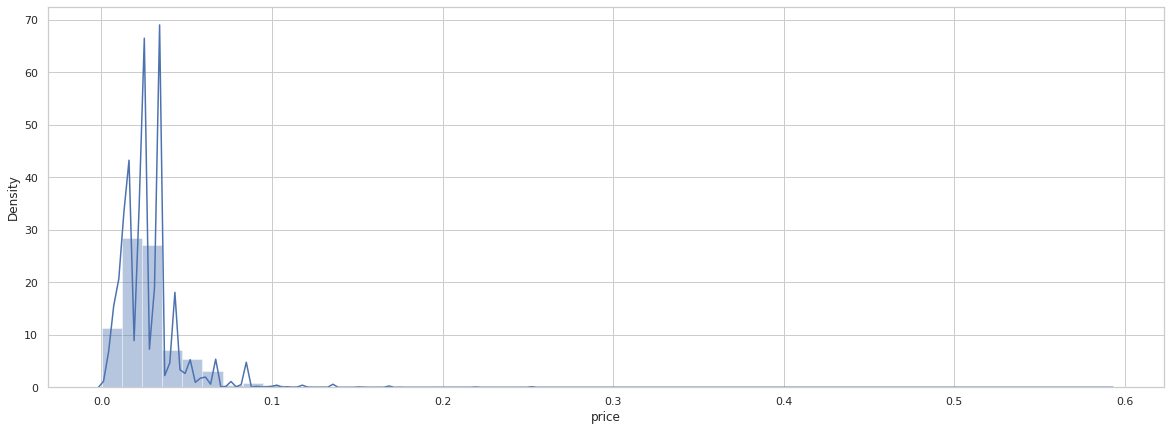

[2022-02-08 08:57:33] - plot train price 108.477[s]


In [17]:
with Timer(logger=logger, prefix="plot train price"):
    plt.figure(figsize=(20, 7))
    sns.distplot(train_df["price"])
    plt.show()

[2022-02-08 08:57:38] - plot train price boxplot 5.309[s]


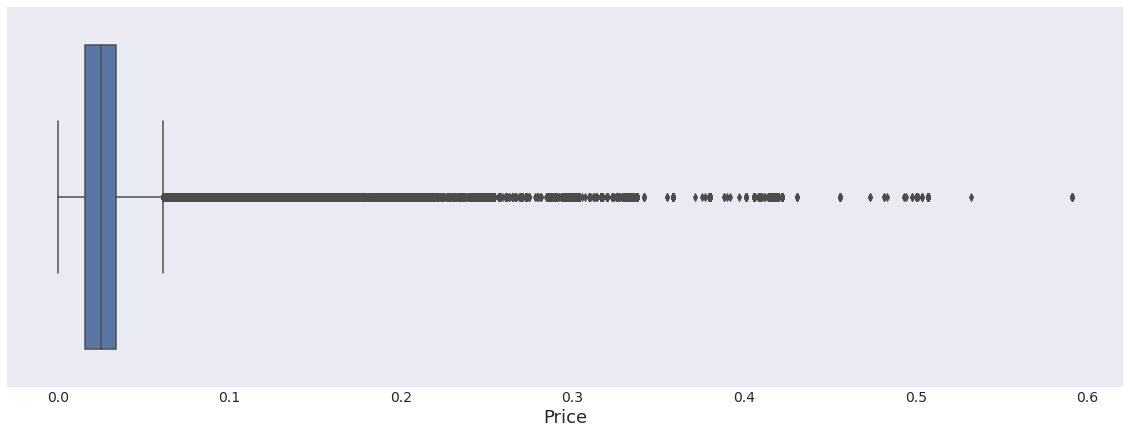

In [18]:
with Timer(logger=logger, prefix="plot train price boxplot"):
    plot_boxplot(df=train_df, col_name="price")

In [19]:
with Timer(logger=logger, prefix="plot value count train_df sales_channel_id"):
    plot_value_count(df=train_df, col_name="sales_channel_id")

[2022-02-08 08:57:45] - plot value count train_df sales_channel_id 0.459[s]


## Customer_df

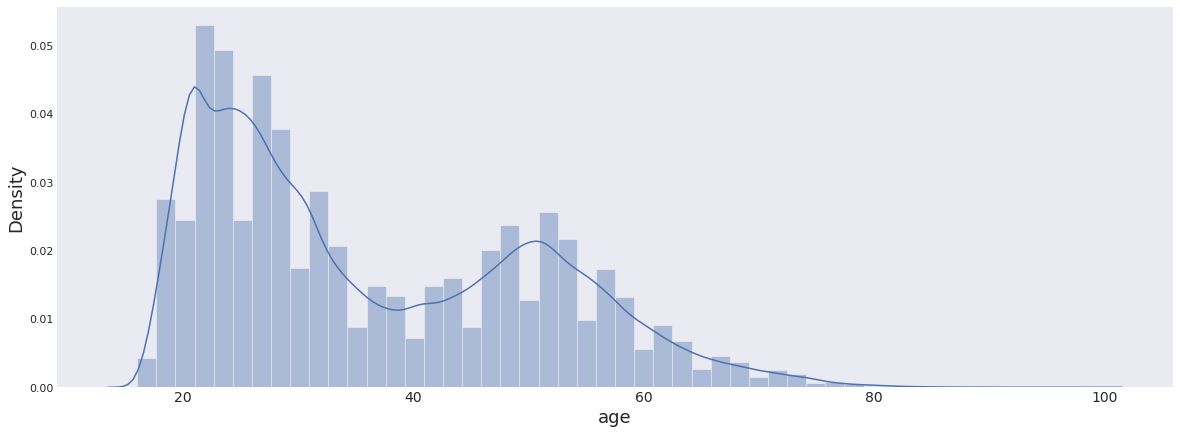

[2022-02-08 08:57:51] - plot customer age distplot 5.524[s]


In [20]:
with Timer(logger=logger, prefix="plot customer age distplot"):
    plt.figure(figsize=(20, 7))
    sns.distplot(customer_df["age"])
    plt.show()

[2022-02-08 08:57:51] - plot customer age boxplot 0.257[s]


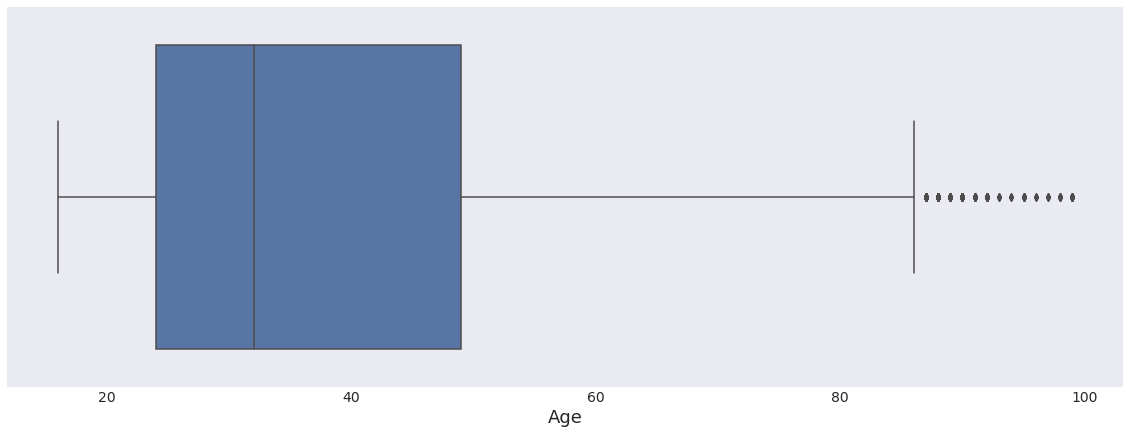

In [21]:
with Timer(logger=logger, prefix="plot customer age boxplot"):
    plot_boxplot(df=customer_df, col_name="age")

In [22]:
with Timer(logger=logger, prefix="plot value count club member status"):
    plot_value_count(df=customer_df, col_name="club_member_status")

[2022-02-08 08:57:51] - plot value count club member status 0.038[s]


In [23]:
with Timer(logger=logger, prefix="plot value count fashion_news_frequency"):
    plot_value_count(df=customer_df, col_name="fashion_news_frequency")

[2022-02-08 08:57:52] - plot value count fashion_news_frequency 0.034[s]


## art_df

In [24]:
with Timer(logger=logger, prefix="value count plot product_group_name"):
    display(art_df["product_group_name"].value_counts())
    plot_value_count(df=art_df, col_name="product_group_name")

Garment Upper body       42741
Garment Lower body       19812
Garment Full body        13292
Accessories              11158
Underwear                 5490
Shoes                     5283
Swimwear                  3127
Socks & Tights            2442
Nightwear                 1899
Unknown                    121
Underwear/nightwear         54
Cosmetic                    49
Bags                        25
Items                       17
Furniture                   13
Garment and Shoe care        9
Stationery                   5
Interior textile             3
Fun                          2
Name: product_group_name, dtype: int64

[2022-02-08 08:57:52] - value count plot product_group_name 0.025[s]


In [25]:
with Timer(logger=logger, prefix="value count plot graphical_appearance_name"):
    display(art_df["graphical_appearance_name"].value_counts())
    plot_value_count(df=art_df, col_name="graphical_appearance_name")

Solid                  49747
All over pattern       17165
Melange                 5938
Stripe                  4990
Denim                   4842
Front print             3215
Placement print         3098
Check                   2178
Colour blocking         1830
Lace                    1513
Other structure         1502
Application/3D          1341
Embroidery              1165
Mixed solid/pattern     1132
Glittering/Metallic      958
Jacquard                 830
Sequin                   806
Dot                      681
Treatment                586
Other pattern            515
Contrast                 376
Metallic                 346
Chambray                 322
Slub                     153
Transparent               86
Mesh                      86
Neps                      66
Unknown                   52
Argyle                    15
Hologram                   8
Name: graphical_appearance_name, dtype: int64

[2022-02-08 08:57:52] - value count plot graphical_appearance_name 0.031[s]


In [26]:
with Timer(logger=logger, prefix="value count plot colour_group_name"):
    display(art_df["colour_group_name"].value_counts())
    plot_value_count(df=art_df, col_name="colour_group_name")

Black              22670
Dark Blue          12171
White               9542
Light Pink          5811
Grey                4487
Light Beige         3356
Blue                3308
Red                 3056
Light Blue          3012
Greenish Khaki      2767
Dark Grey           2731
Off White           2726
Beige               2712
Dark Red            2340
Dark Green          2106
Light Grey          2105
Pink                2063
Yellow              1645
Light Orange        1520
Yellowish Brown     1471
Gold                1377
Dark Beige          1084
Light Turquoise     1027
Light Yellow         984
Dark Orange          886
Dark Pink            818
Green                815
Orange               779
Other Pink           750
Silver               709
Light Green          681
Dark Yellow          574
Light Purple         553
Dark Turquoise       473
Turquoise            435
Dark Purple          315
Light Red            285
Greyish Beige        226
Other Yellow         225
Purple               182


[2022-02-08 08:57:52] - value count plot colour_group_name 0.034[s]


In [27]:
with Timer(logger=logger, prefix="value count plot perceived_colour_value_name"):
    display(art_df["perceived_colour_value_name"].value_counts())
    plot_value_count(df=art_df, col_name="perceived_colour_value_name")

Dark            42706
Dusty Light     22152
Light           15739
Medium Dusty    12630
Bright           6471
Medium           5711
Undefined         105
Unknown            28
Name: perceived_colour_value_name, dtype: int64

[2022-02-08 08:57:53] - value count plot perceived_colour_value_name 0.030[s]


In [28]:
with Timer(logger=logger, prefix="value count plot perceived_colour_master_name"):
    display(art_df["perceived_colour_master_name"].value_counts())
    plot_value_count(df=art_df, col_name="perceived_colour_master_name")

Black              22585
Blue               18469
White              12665
Pink                9403
Grey                8924
Red                 5878
Beige               5657
Green               3526
Khaki green         3181
Yellow              3121
Orange              2734
Brown               2269
Metal               2180
Turquoise           1829
Mole                1223
Lilac Purple        1100
Unknown              685
undefined            105
Yellowish Green        5
Bluish Green           3
Name: perceived_colour_master_name, dtype: int64

[2022-02-08 08:57:53] - value count plot perceived_colour_master_name 0.037[s]


In [29]:
with Timer(logger=logger, prefix="value count plot department_name"):
    display(art_df["department_name"].value_counts())
    plot_value_count(df=art_df, col_name="department_name")

Jersey                                      4604
Knitwear                                    3503
Trouser                                     2655
Blouse                                      2362
Dress                                       2087
Swimwear                                    2075
Kids Girl Jersey Fancy                      2032
Expressive Lingerie                         1921
Young Girl Jersey Fancy                     1874
Jersey Fancy                                1754
Jersey Basic                                1514
Kids Boy Jersey Fancy                       1488
Tops Fancy Jersey                           1429
Jersey fancy                                1402
Dresses                                     1354
Basic 1                                     1339
Jewellery                                   1163
Shirt                                       1153
Baby basics                                 1147
Tops Knitwear                               1115
Young Boy Jersey Fan

[2022-02-08 08:57:53] - value count plot department_name 0.037[s]


In [30]:
with Timer(logger=logger, prefix="value count plot index name"):
    display(art_df["index_name"].value_counts())
    plot_value_count(df=art_df, col_name="index_name")

Ladieswear                        26001
Divided                           15149
Menswear                          12553
Children Sizes 92-140             12007
Children Sizes 134-170             9214
Baby Sizes 50-98                   8875
Ladies Accessories                 6961
Lingeries/Tights                   6775
Children Accessories, Swimwear     4615
Sport                              3392
Name: index_name, dtype: int64

[2022-02-08 08:57:53] - value count plot index name 0.030[s]


In [31]:
with Timer(logger=logger, prefix="value count plot index group name"):
    display(art_df["index_group_name"].value_counts())
    plot_value_count(df=art_df, col_name="index_group_name")

Ladieswear       39737
Baby/Children    34711
Divided          15149
Menswear         12553
Sport             3392
Name: index_group_name, dtype: int64

[2022-02-08 08:57:53] - value count plot index group name 0.028[s]


In [32]:
with Timer(logger=logger, prefix="value count plot section name"):
    display(art_df["section_name"].value_counts())
    plot_value_count(df=art_df, col_name="section_name")

Womens Everyday Collection        7295
Divided Collection                7124
Baby Essentials & Complements     4932
Kids Girl                         4469
Young Girl                        3899
Womens Lingerie                   3598
Girls Underwear & Basics          3490
Womens Tailoring                  3376
Kids Boy                          3328
Womens Small accessories          3270
Womens Casual                     2725
Kids Outerwear                    2665
Womens Trend                      2622
Divided Projects                  2364
Young Boy                         2352
H&M+                              2337
Men Underwear                     2322
Mama                              2266
Kids & Baby Shoes                 2142
Boys Underwear & Basics           2034
Womens Shoes                      2026
Ladies H&M Sport                  1894
Womens Swimwear, beachwear        1839
Contemporary Smart                1778
Baby Girl                         1760
Divided Accessories      

[2022-02-08 08:57:54] - value count plot section name 0.026[s]


In [33]:
with Timer(logger=logger, prefix="value count plot garment_group_name"):
    display(art_df["garment_group_name"].value_counts())
    plot_value_count(df=art_df, col_name="garment_group_name")

Jersey Fancy                     21445
Accessories                      11519
Jersey Basic                      8126
Knitwear                          7490
Under-, Nightwear                 7441
Trousers                          6727
Blouses                           5838
Shoes                             5145
Dresses Ladies                    4874
Outdoor                           4501
Unknown                           3873
Trousers Denim                    3100
Swimwear                          2787
Socks and Tights                  2272
Shirts                            2116
Woven/Jersey/Knitted mix Baby     1965
Shorts                            1559
Dresses/Skirts girls              1541
Skirts                            1254
Special Offers                    1061
Dressed                            908
Name: garment_group_name, dtype: int64

[2022-02-08 08:57:54] - value count plot garment_group_name 0.029[s]


In [34]:
with Timer(logger=logger, prefix="value count plot product_type_name"):
    display(art_df["product_type_name"].value_counts())
    plot_value_count(df=art_df, col_name="product_type_name")

Trousers                    11169
Dress                       10362
Sweater                      9302
T-shirt                      7904
Top                          4155
Blouse                       3979
Jacket                       3940
Shorts                       3939
Shirt                        3405
Vest top                     2991
Underwear bottom             2748
Skirt                        2696
Hoodie                       2356
Bra                          2212
Socks                        1889
Leggings/Tights              1878
Sneakers                     1621
Cardigan                     1550
Hat/beanie                   1349
Garment Set                  1320
Swimwear bottom              1307
Bag                          1280
Earring                      1159
Jumpsuit/Playsuit            1147
Pyjama set                   1120
Blazer                       1110
Other accessories            1034
Boots                        1028
Scarf                        1013
Bodysuit      

[2022-02-08 08:57:54] - value count plot product_type_name 0.030[s]


In [35]:
def preprocessing_date(input_df: pd.DataFrame) -> pd.DataFrame:
    date_df = pd.to_datetime(input_df["t_dat"])
    out_df = pd.DataFrame({
        "year":date_df.dt.year,
        "month":date_df.dt.month,
        "day":date_df.dt.day,
        "dayofweek":date_df.dt.dayofweek
    })
    return out_df

with Timer(logger=logger, prefix="preprocessing date"):
    date_df = preprocessing_date(train_df)

[2022-02-08 08:58:08] - preprocessing date 13.919[s]


## date_df

In [36]:
with Timer(logger=logger, prefix="value count year"):
    plot_value_count(date_df, col_name="year")

[2022-02-08 08:58:09] - value count year 0.340[s]


In [37]:
with Timer(logger=logger, prefix="plot value count month"):
    plot_value_count(df=date_df, col_name="month")

[2022-02-08 08:58:10] - plot value count month 0.367[s]


In [38]:
with Timer(logger=logger, prefix="plot value count day"):
    plot_value_count(df=date_df, col_name="day")

[2022-02-08 08:58:10] - plot value count day 0.364[s]


In [39]:
with Timer(logger=logger, prefix="plot value count dayofweek"):
    plot_value_count(df=date_df, col_name="dayofweek")

[2022-02-08 08:58:11] - plot value count dayofweek 0.339[s]


## nlp_date

In [40]:
def preprocessing_nlp(input_df: pd.DataFrame) -> pd.DataFrame:
    nlp_data = input_df[["detail_desc"]].copy()
    nlp_data["string_count"] = nlp_data["detail_desc"].apply(lambda x: len(x))
    nlp_data["word_count"] = nlp_data["detail_desc"].apply(lambda x: len(x.split()))
    return nlp_data

In [41]:
with Timer(logger=logger, prefix="preprocess nlp"):
    nlp_data = preprocessing_nlp(art_df)

[2022-02-08 08:58:11] - preprocess nlp 0.139[s]


In [42]:
nlp_data.describe()

,string_count,word_count
count,105126.0000,105126.0000
mean,142.1619,23.9022
std,68.0949,11.6233
min,11.0000,2.0000
25%,94.0000,16.0000
50%,132.0000,22.0000
75%,178.0000,30.0000
max,764.0000,121.0000


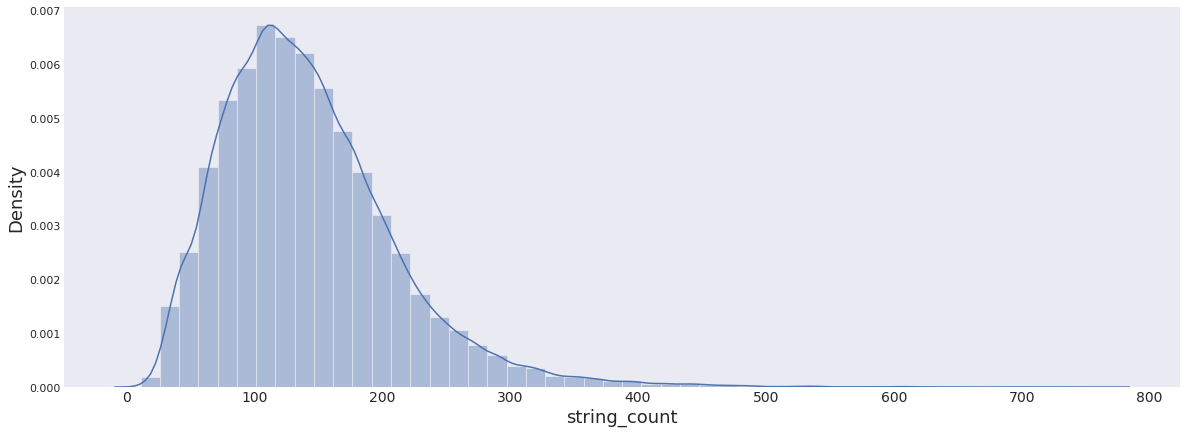

[2022-02-08 08:58:13] - string count 0.818[s]


In [43]:
with Timer(logger=logger, prefix="string count"):
    plt.figure(figsize=(20, 7))
    sns.distplot(nlp_data["string_count"])
    plt.show()

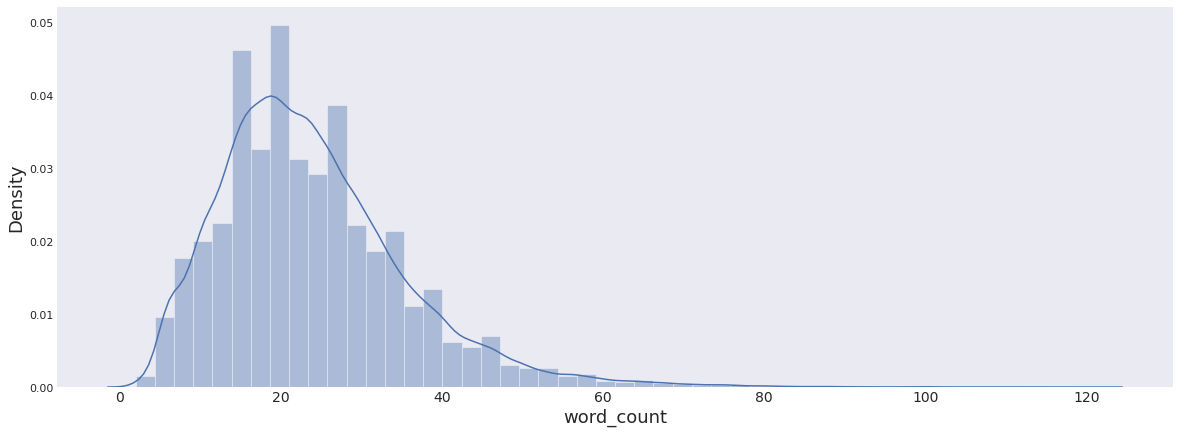

[2022-02-08 08:58:14] - word count 0.797[s]


In [44]:
with Timer(logger=logger, prefix="word count"):
    plt.figure(figsize=(20, 7))
    sns.distplot(nlp_data["word_count"])
    plt.show()

In [45]:
from vis.ngram_plot import create_top_ngram_word_plot
from vis.wordcloud_plot import create_wordcloud

In [46]:
nlp_data.dropna(inplace=True)

## with stopwords

************************************************************************************************************************


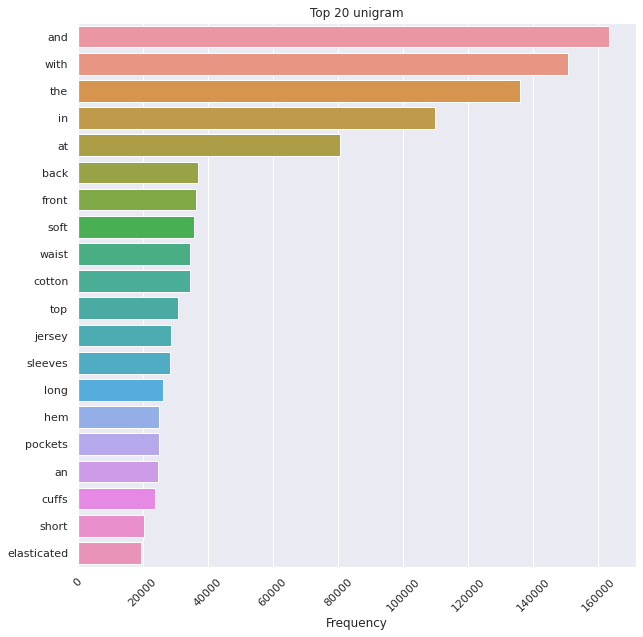

************************************************************************************************************************


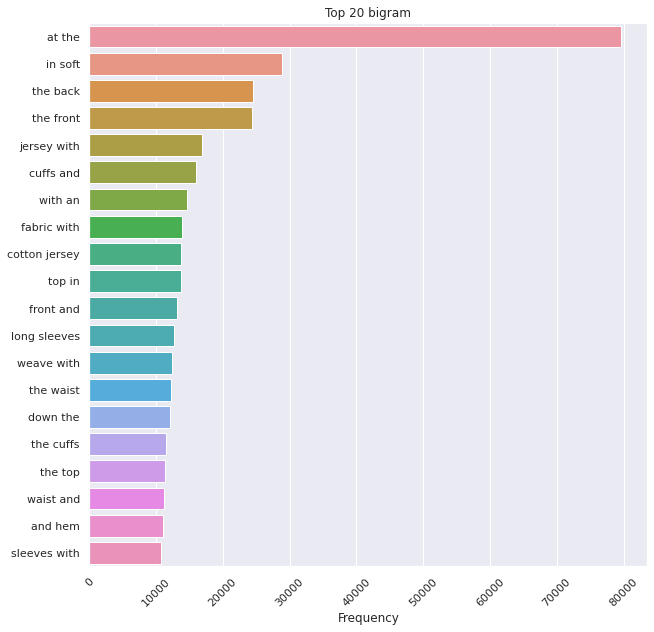

************************************************************************************************************************


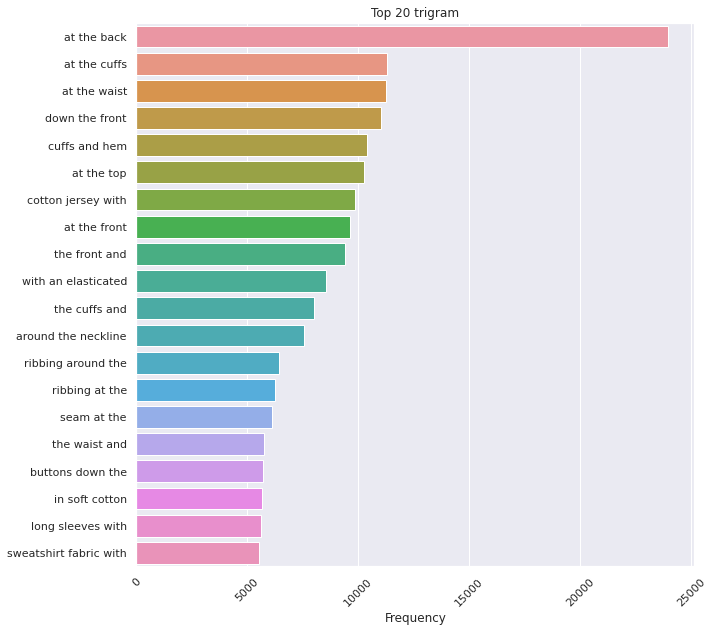

[2022-02-08 08:58:39] - n_gram_word_plot 24.464[s]


In [47]:
with Timer(logger=logger, prefix="n_gram_word_plot"):
    create_top_ngram_word_plot(input_df=nlp_data, col="detail_desc")

detail_desc


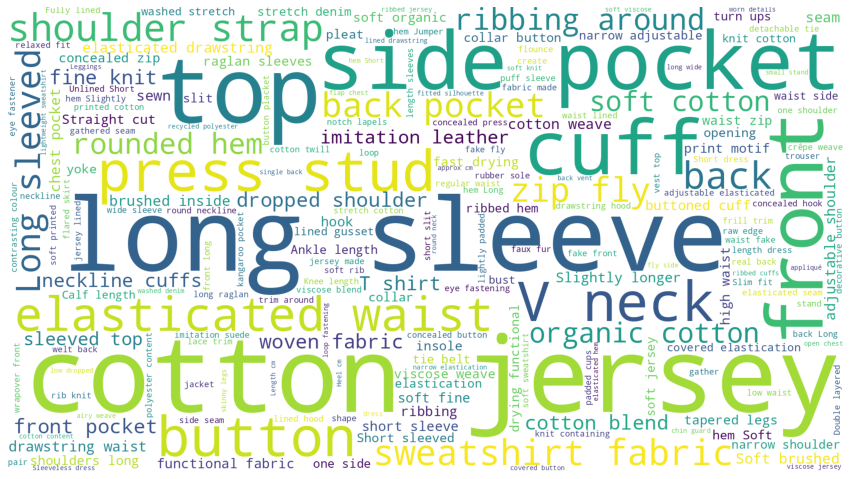

[2022-02-08 08:58:52] - create_wordcloud_plot 12.441[s]


In [48]:
with Timer(logger=logger, prefix="create_wordcloud_plot"):
    create_wordcloud(input_df=nlp_data, col="detail_desc")

In [49]:
import nltk
from nltk.corpus import stopwords

## removing stopwords

************************************************************************************************************************


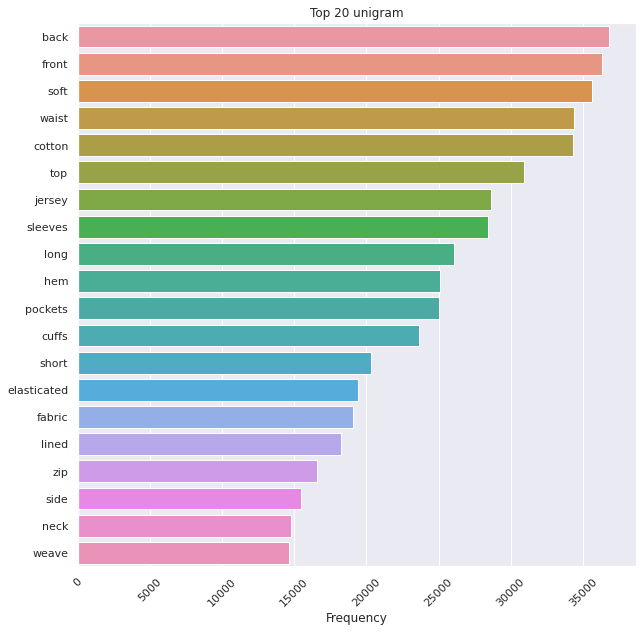

************************************************************************************************************************


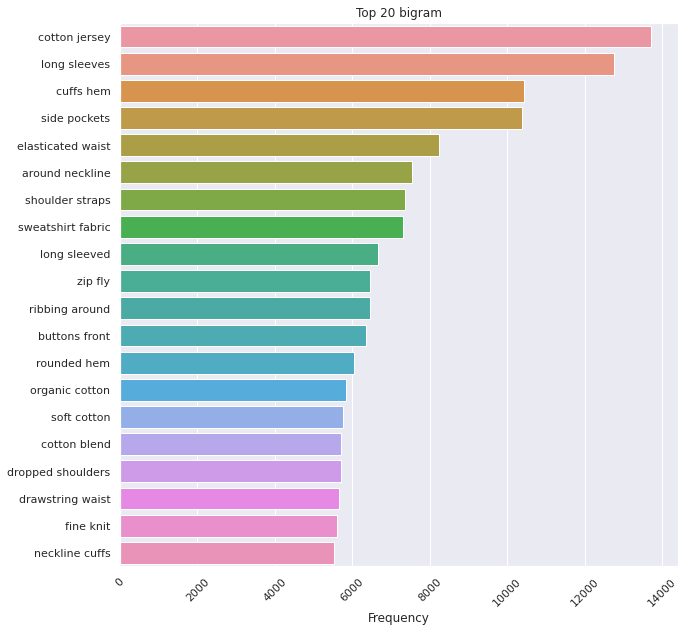

************************************************************************************************************************


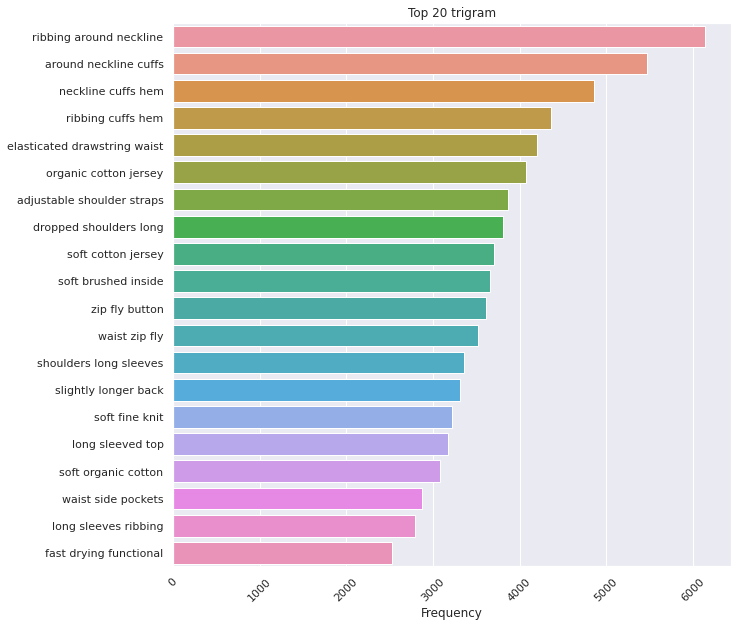

[2022-02-08 08:59:17] - n_gram_word_plot 23.625[s]


In [50]:
with Timer(logger=logger, prefix="n_gram_word_plot"):
    create_top_ngram_word_plot(input_df=nlp_data, col="detail_desc", stop_words=stopwords.words('english'))

detail_desc


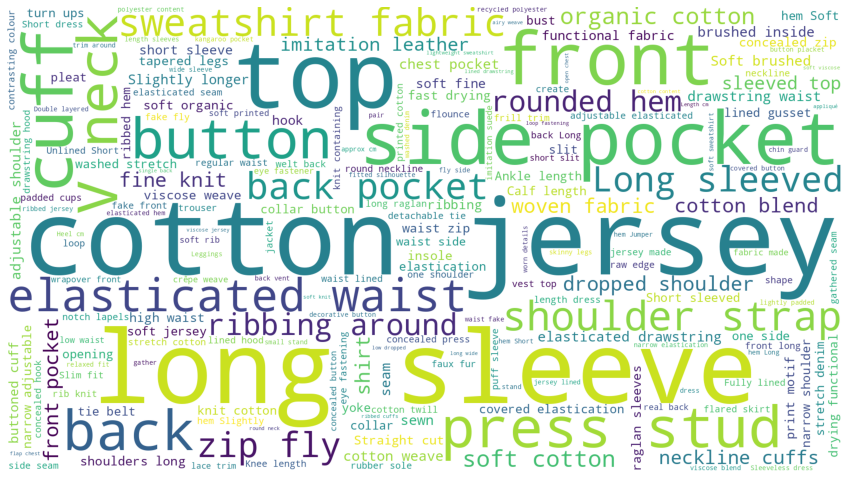

[2022-02-08 08:59:30] - create_wordcloud_plot 12.703[s]


In [51]:
with Timer(logger=logger, prefix="create_wordcloud_plot"):
    create_wordcloud(input_df=nlp_data, col="detail_desc", stopwords=stopwords.words("english"))

In [52]:
print(train_df.shape)
train_df.head()

(31788324, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.0508,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.0305,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.0152,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.0169,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.0169,2


In [53]:
print(customer_df.shape)
customer_df.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0000,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0000,1.0000,ACTIVE,Regularly,52.0000,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [54]:
print(art_df.shape)
art_df.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [55]:
from vis.venn_plot import plot_intersection

1362281
1371980


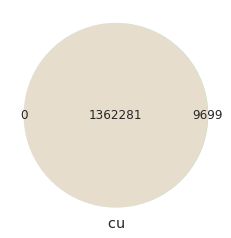

In [56]:
print(train_df["customer_id"].nunique())
print(customer_df["customer_id"].nunique())
plot_intersection(train_df, customer_df, "customer_id", "customer_id")

104547
105542


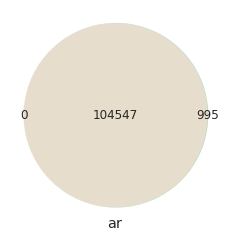

In [57]:
print(train_df["article_id"].nunique())
print(art_df["article_id"].nunique())
plot_intersection(train_df, art_df, "article_id", "article_id")

## pd.merge vs pd.join

In [58]:
with Timer(logger=logger, prefix="pd.merge train_df, customer_df"):
    pd.merge(train_df, customer_df, on=["customer_id"], how="left")

[2022-02-08 09:00:13] - pd.merge train_df, customer_df 24.593[s]


In [59]:
with Timer(logger=logger, prefix="pd.merge train_df art_df"):
    pd.merge(train_df, art_df, on=["article_id"], how="left")

[2022-02-08 09:00:24] - pd.merge train_df art_df 11.310[s]


In [60]:
with Timer(logger=logger, prefix="pd.join train_df customer_df"):
    train_df.join(customer_df.set_index("customer_id"), how="left", on="customer_id")

[2022-02-08 09:00:44] - pd.join train_df customer_df 19.268[s]


In [61]:
with Timer(logger=logger, prefix="pd.join train_df art_df"):
    train_df.join(art_df.set_index("article_id"), how="left", on="article_id")

[2022-02-08 09:00:52] - pd.join train_df art_df 7.497[s]


In [62]:
with Timer(logger=logger, prefix="pd.join train_df art_df customer_df"):
    train_df = train_df.join(customer_df.set_index("customer_id"), how="left", on="customer_id")
    train_df = train_df.join(art_df.set_index("article_id"), how="left", on="article_id")

[2022-02-08 09:01:20] - pd.join train_df art_df customer_df 28.252[s]


In [63]:
transaction = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
transaction = reduce_mem_usage(transaction)

Memory usage of dataframe is 1212.63 MB
Memory usage after optimization is: 436.77 MB
Decreased by 64.0%


## Store df

In [64]:
from utils.util import Util

In [65]:
with Timer(logger, prefix="store pickle"):
    Util.dump_df(train_df, "train.pkl", is_pickle=True)
    Util.dump_df(art_df, "art.pkl", is_pickle=True)
    Util.dump_df(customer_df, "customer.pkl", is_pickle=True)
    Util.dump_df(transaction, "transaction.pkl", is_pickle=True)

[2022-02-08 09:02:40] - store pickle 12.669[s]


In [66]:
import gc
del customer_df, transaction, art_df
gc.collect()

7583